In [1]:
# Load modules of main code

%run -i '../../../clustinator/input.py'
%run -i '../../../clustinator/markovchain.py'

In [2]:
# read example data (similarly formatted as RabbitMQ input)

with open('../../data/specj-input.json') as json_file:
    data_input = Input(json_file.read())

session, states = data_input.sessions()

markov_chain = MarkovChain(session, states)
markov_chain, session_ids = markov_chain.csr_sparse_matrix()

<Figure size 432x288 with 0 Axes>

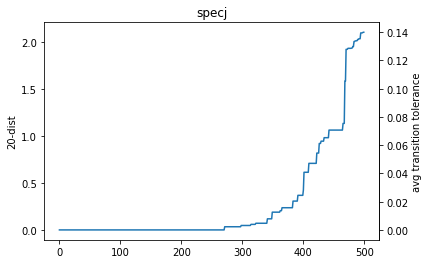

In [17]:
# Calculate and plot k-nearest neighbor distance

import io
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 20

nbrs = NearestNeighbors(n_neighbors=min_samples).fit(markov_chain)
distances, _ = nbrs.kneighbors(markov_chain)

plt.figure()
_, ax = plt.subplots()

ax.set_title(data_input.get_app_id())

ax.plot(sorted(distances[:,min_samples-1]))
ax.set_ylabel('%r-dist' % min_samples)

n = len(states) - 1

def eps2att(x):
    return x / n

def att2eps(x):
    return n * x

secax = ax.secondary_yaxis('right', functions=(eps2att, att2eps))
secax.set_ylabel('avg transition tolerance')

buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

image = buf.read()
buf.close()

In [8]:
# Setup RabbitMQ (requires RabbitMQ running at localhost)

import pika

connection = pika.BlockingConnection(pika.ConnectionParameters(host='localhost'))
channel = connection.channel()

exchange_name = 'test.image'
queue_name = 'test.image'

channel.exchange_declare(exchange=exchange_name, exchange_type='topic', durable=False, auto_delete=True)

result = channel.queue_declare(queue_name, auto_delete=True, durable=False)
channel.queue_bind(queue=queue_name, exchange=exchange_name, routing_key='#')

<METHOD(['channel_number=1', 'frame_type=1', 'method=<Queue.BindOk>'])>

In [12]:
# Send the image to RabbitMQ

channel.basic_publish(exchange=exchange_name, routing_key='specj', body=image)

In [13]:
# Read the image from RabbitMQ

def callback(ch, method, properties, body):
    f=open('outputimage.jpg','wb')
    f.write(body)
    f.close()

channel.basic_consume(queue=queue_name, on_message_callback=callback, auto_ack=True)

#channel.start_consuming()
channel.connection.process_data_events(time_limit=10)

# Test actual implementation

In [21]:
input_exchange = 'continuity.task.clustinator.knndistance'

result_exchange = 'continuity.event.clustinator.imagegenerated'
result_queue = 'test.received.image'

# define exchanges and queues

connection = pika.BlockingConnection(pika.ConnectionParameters(host='localhost'))
channel = connection.channel()

channel.exchange_declare(exchange=result_exchange, exchange_type='topic', durable=False, auto_delete=True)

result = channel.queue_declare(result_queue, auto_delete=True, durable=False)
channel.queue_bind(queue=result_queue, exchange=result_exchange, routing_key='#')

channel.basic_consume(queue=result_queue, on_message_callback=callback, auto_ack=True)

# publish message

with open('../../data/specj-input.json') as json_file:
    json_input = json_file.read()

content_type = pika.spec.BasicProperties(content_type='application/json')
channel.basic_publish(exchange=input_exchange, routing_key='specj', body=json_input, properties=content_type)

# wait for response

#channel.start_consuming()
channel.connection.process_data_events(time_limit=60)